In [111]:
import os
import sys
sys.path.append(os.path.abspath(".."))

In [112]:
import torch
import seaborn as sns
import ristretto.activations as ra
import ristretto.models as rm
import ristretto.utils as ru
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
# from torch.utils.tensorboard import SummaryWriter

In [113]:
# set pytorch precision
torch.set_default_tensor_type(torch.FloatTensor)
torch.set_default_dtype(torch.float32)
# activate 
ra.ReLUFunction.print_when_zero = True

In [191]:
def get_epoch_val(metrics, epochs=10, batch_size=128):
    """Gets the accuracy of an epoch for a given model."""
    epoch_val = np.arange(epochs)
    model_epoch =[]

    for m in range(len(metrics)):
        for i in range(epochs):
            len_epoch = int(len(metrics[m]["validation"]['correct'])/epochs)
            index = i*len_epoch
            epoch_val[i] = (metrics[m]["validation"]['correct'][index:index+len_epoch].sum())
            aux = epoch_val.copy()/10000
        model_epoch.append(aux)
    return model_epoch


def get_epoch_train(metrics, epochs=10, batch_size=128):
    """Gets the accuracy of an epoch for a given model."""
    epoch_val = np.arange(epochs)
    model_epoch =[]

    for m in range(len(metrics)):
        for i in range(epochs):
            len_epoch = int(len(metrics[m]["train"]['loss'])/epochs)
            index = i*len_epoch
            epoch_val[i] = (metrics[m]["train"]['loss'][index:index+len_epoch].sum())
            aux = epoch_val.copy()/600000
        model_epoch.append(aux)
    return model_epoch

In [115]:
depths  = [3]
dims    = [200]
hidden_dims = []

activations = [0, 1, 2, 4, 8]

for dim in dims:
    for depth in depths:
        hidden_dims.append([dim] * depth)

new_models = []
for activition in activations:
    for hidden_dim in hidden_dims:
        new_models.append(rm.FullyConnected(activation=partial(ra.ReLU, activition), hidden_dims=hidden_dim, seed=42069))
    
      
model_32 = [rm.FullyConnected(activation=partial(ra.ReLU, 0), hidden_dims=hidden_dims[0], seed=42069)]

In [116]:
#This is just to know the index of the models for the plots. 
aux = 0
rel = 0 

for activation in activations:
    for dim in dims:
        for depth in depths:
            print(f"index {aux +1} --> model {aux+2}")
            print(f"Activation: {activation} alpha: {rel}, dim: {dim}, depth: {depth}")
            print(f"Model: {new_models[aux]}")
            aux += 1
    rel += 1

index 1 --> model 2
Activation: 0 alpha: 0, dim: 200, depth: 3
Model: FullyConnected(
  (sequence): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=10, bias=True)
  )
)
index 2 --> model 3
Activation: 1 alpha: 1, dim: 200, depth: 3
Model: FullyConnected(
  (sequence): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=10, bias=True)
  )
)
index 3 --> model 4
Activation: 2 alpha: 2, dim: 200, depth: 3
Model: FullyConnected(
  (sequence): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)


In [117]:
models_32 = model_32 + new_models

# activate 
ra.ReLUFunction.print_when_zero = True

epochs = 20
metrics_32 = ru.train_multiple_models(
    models_32,
    ru.default.DATA_LOADERS['MNIST'],
    epochs=epochs,
    metrics_fn=lambda m, p, y: {"weight_sum": ru.get_weight_sum(m)}
)

===== Model 1 (FullyConnected) =====
---------- Epoch  1 ----------
Found 1 item with input == 0
Validation
    loss:     1.769e-01
    accuracy: 94.40
---------- Epoch  2 ----------
Validation
    loss:     1.063e-01
    accuracy: 96.75
---------- Epoch  3 ----------
Validation
    loss:     1.041e-01
    accuracy: 96.70
---------- Epoch  4 ----------
Validation
    loss:     1.726e-01
    accuracy: 95.12
---------- Epoch  5 ----------
Validation
    loss:     1.314e-01
    accuracy: 96.25
---------- Epoch  6 ----------
Validation
    loss:     9.974e-02
    accuracy: 97.29
---------- Epoch  7 ----------
Validation
    loss:     1.022e-01
    accuracy: 97.28
---------- Epoch  8 ----------
Validation
    loss:     1.062e-01
    accuracy: 97.20
---------- Epoch  9 ----------
Validation
    loss:     1.104e-01
    accuracy: 97.16
---------- Epoch 10 ----------
Validation
    loss:     9.858e-02
    accuracy: 97.71
---------- Epoch 11 ----------
Validation
    loss:     9.781e-02
    accu

Took 20min to run 

In [118]:
import pickle

with open("output1_32.bin", "wb") as output: #Im storing the esperiment results for further testing 
    pickle.dump(metrics_32, output)
    output.close()
    

In [119]:

print("numbers models: ",len(metrics_32),"Which contain: ")
print(metrics_32[0].keys())
print('train contains: ')
print(metrics_32[0]['train'].keys()) 
print('validation contains: ')
print(metrics_32[0]['validation'].keys()) 


numbers models:  6 Which contain: 
dict_keys(['train', 'validation'])
train contains: 
Index(['loss', 'accuracy', 'weight_sum'], dtype='object')
validation contains: 
Index(['loss', 'correct', 'accuracy', 'weight_sum'], dtype='object')


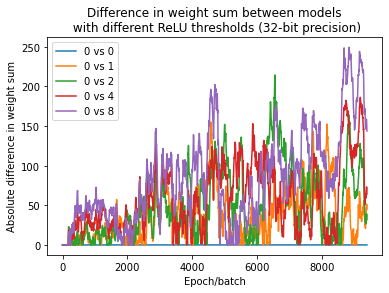

In [144]:
diff = pd.DataFrame({
    "0 vs 0": np.abs(metrics_32[0]["train"]['weight_sum'] - metrics_32[1]["train"]['weight_sum']),
    "0 vs 1": np.abs(metrics_32[0]["train"]['weight_sum'] - metrics_32[2]["train"]['weight_sum']),
    "0 vs 2": np.abs(metrics_32[0]["train"]['weight_sum'] - metrics_32[3]["train"]['weight_sum']),
    "0 vs 4": np.abs(metrics_32[0]["train"]['weight_sum'] - metrics_32[4]["train"]['weight_sum']),
    "0 vs 8": np.abs(metrics_32[0]["train"]['weight_sum'] - metrics_32[5]["train"]['weight_sum'])
})
sns.lineplot(data=diff, dashes=False)
plt.xlabel("Epoch/batch")
plt.ylabel("Absolute difference in weight sum")
plt.title("Difference in weight sum between models\n with different ReLU thresholds (32-bit precision)");

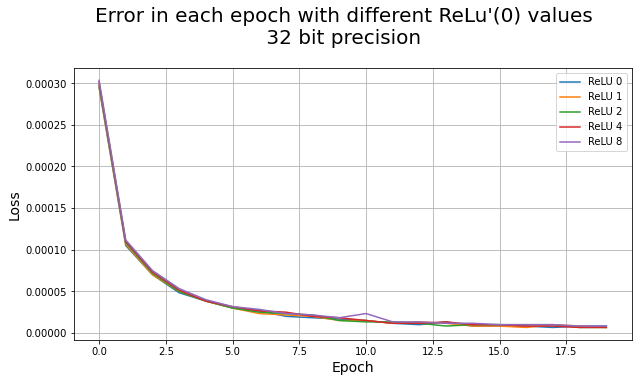

In [194]:
loss_32 = get_epoch_train(metrics_32, epochs=epochs, batch_size=128)

fig = plt.figure(figsize=(10,5))
plt.plot(loss_32[1], label='ReLU 0')
plt.plot(loss_32[2], label='ReLU 1')
plt.plot(loss_32[3], label='ReLU 2')
plt.plot(loss_32[4], label='ReLU 4')
plt.plot(loss_32[5], label='ReLU 8')
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.suptitle("Error in each epoch with different ReLu'(0) values\n 32 bit precision ", fontsize=20, y=1.05)
plt.legend()
plt.grid()
plt.show()

In [121]:
model32_epoch = get_epoch_val(metrics_32, epochs=epochs, batch_size=128)

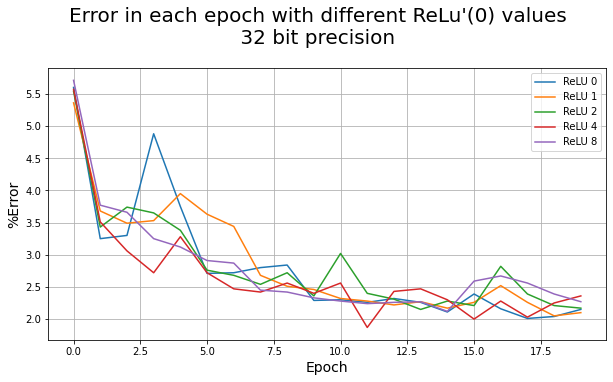

In [181]:
fig = plt.figure(figsize=(10,5))
plt.plot((1-model32_epoch[1])*100, label='ReLU 0')
plt.plot((1-model32_epoch[2])*100, label='ReLU 1')
plt.plot((1-model32_epoch[3])*100, label='ReLU 2')
plt.plot((1-model32_epoch[4])*100, label='ReLU 4')
plt.plot((1-model32_epoch[5])*100, label='ReLU 8')
plt.ylabel('%Error', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.suptitle("Error in each epoch with different ReLu'(0) values\n 32 bit precision ", fontsize=20, y=1.05)
plt.legend()
plt.grid()
plt.show()

### When trained with 16-bit precision the difference between the models is even greater

In [123]:
# set pytorch precision
torch.set_default_tensor_type(torch.FloatTensor)
torch.set_default_dtype(torch.bfloat16)

In [124]:
depths  = [3]
dims    = [200]
hidden_dims = []

activations = [0, 1, 2, 4, 8]

for dim in dims:
    for depth in depths:
        hidden_dims.append([dim] * depth)

new_models_16 = []
for activition in activations:
    for hidden_dim in hidden_dims:
        new_models_16.append(rm.FullyConnected(activation=partial(ra.ReLU, activition), hidden_dims=hidden_dim, seed=42069))
    
          
        
model_16 = [rm.FullyConnected(activation=partial(ra.ReLU, 0), hidden_dims=hidden_dims[0], seed=42069)]

In [125]:
#This is just to know the index of the models for the plots. 
aux = 0
rel = 0 

for activation in activations:
    for dim in dims:
        for depth in depths:
            print(f"index {aux +1} --> model {aux+2}")
            print(f"Activation: {activation} alpha: {rel}, dim: {dim}, depth: {depth}")
            print(f"Model: {new_models_16[aux]}")
            aux += 1
    rel += 1

index 1 --> model 2
Activation: 0 alpha: 0, dim: 200, depth: 3
Model: FullyConnected(
  (sequence): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=10, bias=True)
  )
)
index 2 --> model 3
Activation: 1 alpha: 1, dim: 200, depth: 3
Model: FullyConnected(
  (sequence): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=10, bias=True)
  )
)
index 3 --> model 4
Activation: 2 alpha: 2, dim: 200, depth: 3
Model: FullyConnected(
  (sequence): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)


In [126]:
epochs = 20
models_16 = model_16 + new_models_16

metrics_16 = ru.train_multiple_models(
    models_16,
    ru.default.DATA_LOADERS['MNIST'],
    epochs=epochs,
    metrics_fn=lambda m, p, y: {"weight_sum": ru.get_weight_sum(m)}
)

===== Model 1 (FullyConnected) =====
---------- Epoch  1 ----------
Found 7 items with input == 0
Found 2 items with input == 0
Found 3 items with input == 0
Found 4 items with input == 0
Found 4 items with input == 0
Found 3 items with input == 0
Found 1 item with input == 0
Found 2 items with input == 0
Found 2 items with input == 0
Found 4 items with input == 0
Found 2 items with input == 0
Found 2 items with input == 0
Found 1 item with input == 0
Found 2 items with input == 0
Found 1 item with input == 0
Found 2 items with input == 0
Found 1 item with input == 0
Found 1 item with input == 0
Found 3 items with input == 0
Found 1 item with input == 0
Found 1 item with input == 0
Found 1 item with input == 0
Found 2 items with input == 0
Found 2 items with input == 0
Found 1 item with input == 0
Found 2 items with input == 0
Found 1 item with input == 0
Found 1 item with input == 0
Found 1 item with input == 0
Found 1 item with input == 0
Found 2 items with input == 0
Found 2 items w

Ran in 12 30.4 min

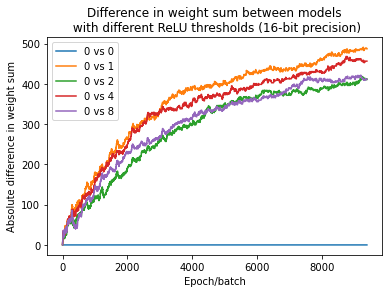

In [143]:
diff = pd.DataFrame({
    "0 vs 0": np.abs(metrics_16[0]["train"]['weight_sum'] - metrics_16[1]["train"]['weight_sum']),
    "0 vs 1": np.abs(metrics_16[0]["train"]['weight_sum'] - metrics_16[2]["train"]['weight_sum']),
    "0 vs 2": np.abs(metrics_16[0]["train"]['weight_sum'] - metrics_16[3]["train"]['weight_sum']),
    "0 vs 4": np.abs(metrics_16[0]["train"]['weight_sum'] - metrics_16[4]["train"]['weight_sum']),
    "0 vs 8": np.abs(metrics_16[0]["train"]['weight_sum'] - metrics_16[5]["train"]['weight_sum'])
})

sns.lineplot(data=diff, dashes=False)
plt.xlabel("Epoch/batch")
plt.ylabel("Absolute difference in weight sum")
plt.title("Difference in weight sum between models\n with different ReLU thresholds (16-bit precision)");

In [188]:
loss_16 = get_epoch_train(metrics_16, epochs=20, batch_size=128)

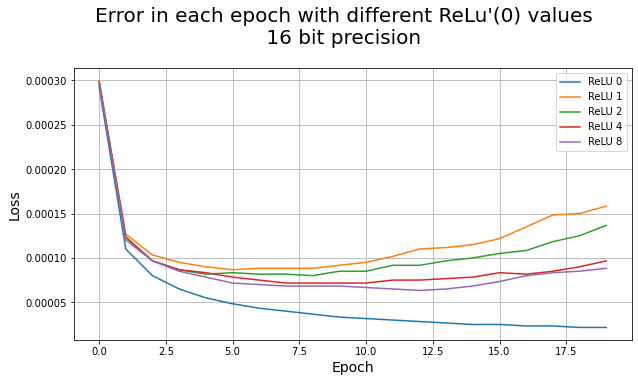

In [190]:
fig = plt.figure(figsize=(10,5))
plt.plot(loss_16[1], label='ReLU 0')
plt.plot(loss_16[2], label='ReLU 1')
plt.plot(loss_16[3], label='ReLU 2')
plt.plot(loss_16[4], label='ReLU 4')
plt.plot(loss_16[5], label='ReLU 8')
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.suptitle("Error in each epoch with different ReLu'(0) values\n 16 bit precision ", fontsize=20, y=1.05)
plt.legend()
plt.grid()
plt.show()

In [ ]:

model16_epoch = get_epoch_val(metrics_16, epochs=20, batch_size=128)

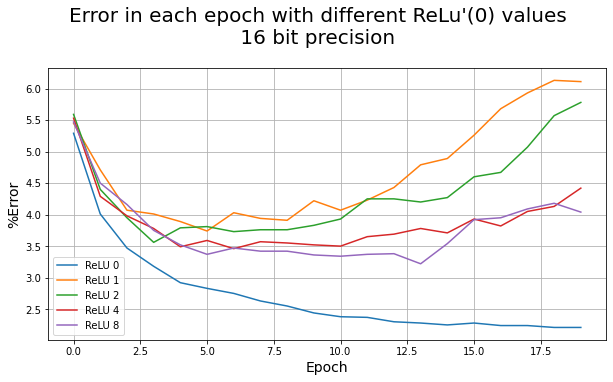

In [180]:
fig = plt.figure(figsize=(10,5))
plt.plot((1-model16_epoch[1])*100, label='ReLU 0')
plt.plot((1-model16_epoch[2])*100, label='ReLU 1')
plt.plot((1-model16_epoch[3])*100, label='ReLU 2')
plt.plot((1-model16_epoch[4])*100, label='ReLU 4')
plt.plot((1-model16_epoch[5])*100, label='ReLU 8')
plt.ylabel('%Error', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.suptitle("Error in each epoch with different ReLu'(0) values\n 16 bit precision ", fontsize=20, y=1.05)
plt.legend()
plt.grid()
plt.show()

In [130]:
with open("output1_16.bin", "wb") as output: # I'm storing the esperiment results for further testing 
    pickle.dump(metrics_16, output)
    output.close()

Additional plots 

In [131]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

with open("output1_16.bin", "rb") as data:
    metrics_16 = pickle.load(data)
    
with open("output1_32.bin", "rb") as data:
    metrics_32 = pickle.load(data)
    
df_16 = pd.DataFrame(metrics_16)
df_32 = pd.DataFrame(metrics_32)
batch = 128
alphas = [0,0,1,2,4,8]

In [133]:
new_df_16 = pd.DataFrame(columns=['relu', 'test_accuracy'])

for i in range(len(alphas)):
    for j in range(len(metrics_16[i]["validation"]["loss"].values)):
        new_df_16 = new_df_16.append({'relu': alphas[i], 'test_accuracy': metrics_16[i]['validation']['correct'].values[j] /batch}, ignore_index=True);

new_df_32 = pd.DataFrame(columns=['relu', 'test_accuracy'])
for i in range(len(alphas)):
    for j in range(len(metrics_32[i]["validation"]["loss"].values)):
        new_df_32 = new_df_32.append({'relu': alphas[i], 'test_accuracy': metrics_32[i]['validation']['correct'].values[j] /batch}, ignore_index=True);


C:\Users\hecma\AppData\Local\Temp\ipykernel_42012\2802421776.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df_16 = new_df_16.append({'relu': alphas[i], 'test_accuracy': metrics_16[i]['validation']['correct'].values[j] /batch}, ignore_index=True);
C:\Users\hecma\AppData\Local\Temp\ipykernel_42012\2802421776.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df_16 = new_df_16.append({'relu': alphas[i], 'test_accuracy': metrics_16[i]['validation']['correct'].values[j] /batch}, ignore_index=True);
C:\Users\hecma\AppData\Local\Temp\ipykernel_42012\2802421776.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df_16 = new_df_16.append({'relu': alphas[i], 'test_accuracy': metrics_16[i]['validation']['correct'].v

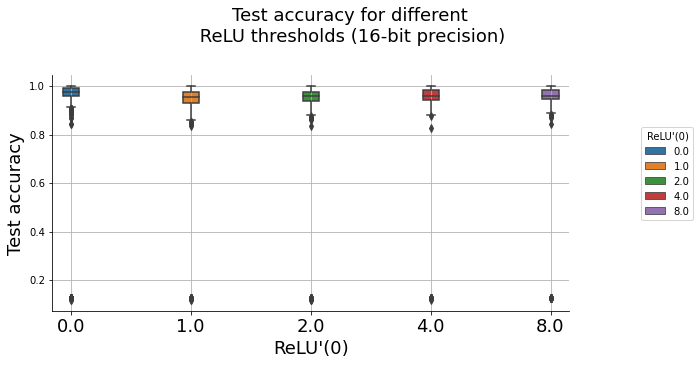

In [134]:
g = sns.catplot(data=new_df_16, x="relu", y="test_accuracy", kind="box", hue="relu", height=4, aspect=2 )
plt.get_figlabels()
plt.legend(title = "ReLU'(0)", loc='best', bbox_to_anchor=(0.75, 0.3, 0.5, 0.5));
plt.suptitle("Test accuracy for different\n ReLU thresholds (16-bit precision)", fontsize=18, y=1.2, x=0.6);
plt.xlabel("ReLU'(0)", fontsize=18); 
plt.ylabel('Test accuracy', fontsize=18);
locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks([-.32,0.84,2,3.16,4.32], labels, fontsize=18);
plt.grid(True)


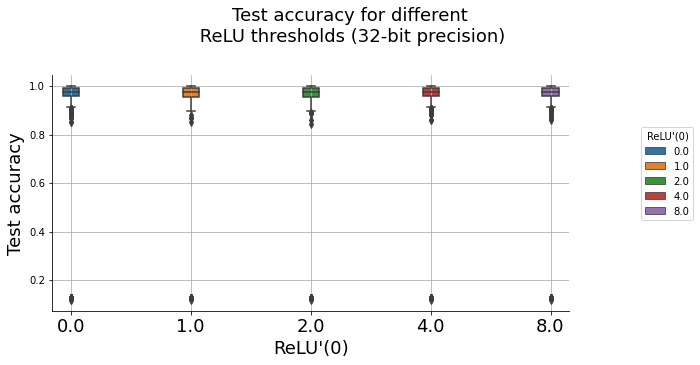

In [135]:
h= sns.catplot(data=new_df_32, x="relu", y="test_accuracy", kind="box", hue="relu", height=4, aspect=2)
plt.legend(title = "ReLU'(0)", loc='best', bbox_to_anchor=(0.75, 0.3, 0.5, 0.5));
plt.suptitle("Test accuracy for different\n ReLU thresholds (32-bit precision)", fontsize=18, y=1.2, x=0.6);
plt.xlabel("ReLU'(0)", fontsize=18);
plt.xticks([-.32,0.84,2,3.16,4.32], labels, fontsize=18);
plt.ylabel('Test accuracy', fontsize=18);
plt.grid(True)

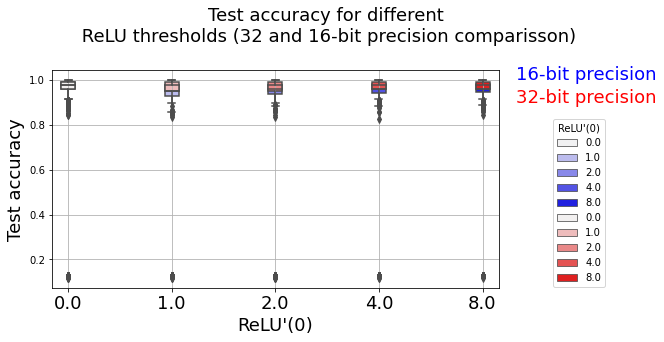

In [164]:
fig = plt.figure(figsize=(8,4))
sns.boxplot(data=new_df_16, x="relu", y="test_accuracy" , hue="relu", color="blue") 
sns.boxplot(data=new_df_32, x="relu", y="test_accuracy", hue="relu" , color="red")
plt.legend(title = "ReLU'(0)", loc='best', bbox_to_anchor=(0.75, 0.3, 0.5, 0.5));
plt.suptitle("Test accuracy for different\n ReLU thresholds (32 and 16-bit precision comparisson)", fontsize=18, y=1.1, x=0.6);
plt.text(4.7, 1, '16-bit precision', fontsize=18, color='blue')
plt.text(4.7, 0.9, '32-bit precision', fontsize=18, color='red')
plt.xlabel("ReLU'(0)", fontsize=18);
plt.xticks([-.32,0.84,2,3.16,4.32], labels, fontsize=18);
plt.ylabel('Test accuracy', fontsize=18);
plt.grid(True)